In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from jupyterthemes import jtplot

#something for converting datetime for x axis
from pandas.plotting import register_matplotlib_converters
import matplotlib.dates as mdates
register_matplotlib_converters()
import math
import seaborn as sns
#jtplot.style()
#jtplot.reset()

In [10]:
# PLOT COLORS
cconfirmed = '#d10f0f'
cdeaths="#333232"
crecovered = "#0c91f0"

In [11]:
sns.set()
# sns.axes_style()

In [12]:
sns.set(style = {'axes.edgecolor': 'black',
                 'grid.color': 'white',
                 'axes.facecolor': '#f5f1df',
                 'xtick.bottom': True,
                'ytick.left': True})

In [13]:
def read_time_series_csv(url):
    
    df_ts = pd.read_csv(url)
    
    df_ts = df_ts.dropna(axis=0, how='all')
    df_ts = df_ts.dropna(axis=1, how='all')

    df_text = df_ts[df_ts.columns[0:2]]
    df_text = df_text.fillna(value = '')
    
    df_val = df_ts[df_ts.columns[2:len(df_ts.columns)]]
    df_val = df_val.fillna(value = 0)
    
    df_ts = pd.concat([df_text,df_val],axis=1)

    return df_ts

In [14]:
def save_one_file(df_confirmed, df_deaths, df_recovered, file_name):
    with pd.ExcelWriter(file_name, engine='xlsxwriter') as writer:
        df_confirmed.to_excel(writer, sheet_name='Confirmed')
        df_deaths.to_excel(writer, sheet_name='Deaths')
        df_recovered.to_excel(writer, sheet_name='Recovered')

In [15]:
url_confirmed = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
url_deaths = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
url_recovered = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"

In [16]:
df_confirmed = read_time_series_csv(url_confirmed)
df_deaths = read_time_series_csv(url_deaths)
df_recovered = read_time_series_csv(url_recovered)

In [17]:
save_one_file(df_confirmed, df_deaths, df_recovered, "TimeSeries.xlsx")

In [18]:
df_confirmed_gb = df_confirmed.groupby('Country/Region').sum()
df_deaths_gb = df_deaths.groupby('Country/Region').sum()
df_recovered_gb = df_recovered.groupby('Country/Region').sum()

df_confirmed_gb = df_confirmed_gb.reset_index()
df_deaths_gb = df_deaths_gb.reset_index()
df_recovered_gb = df_recovered_gb.reset_index()

save_one_file(df_confirmed_gb, df_deaths_gb, df_recovered_gb, "CasesByCountry.xlsx")

In [19]:
print("Shape of df_confirmed_gb: {}".format(df_confirmed_gb.shape))
print("Shape of df_deaths_gb: {}".format(df_deaths_gb.shape))
print("Shape of df_recovered_gb: {}".format(df_recovered_gb.shape))

#printing whole df
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(df_confirmed)

Shape of df_confirmed_gb: (185, 93)
Shape of df_deaths_gb: (185, 93)
Shape of df_recovered_gb: (185, 93)


In [20]:
confirmed_countries = []
for col in df_confirmed_gb.iloc[:,3:].columns:
    s = df_confirmed_gb.apply(lambda x: True if x[col] > 0 else False , axis=1)
    numOfRows = len(s[s == True].index)
    confirmed_countries.append(numOfRows)
#     print('Number of countries with at least 1 confirmed case on {}: {} '.format(col,numOfRows))
print("Number countries with at least one confirmed case daily: {}".format(confirmed_countries))

Number countries with at least one confirmed case daily: [6, 8, 9, 11, 13, 16, 16, 18, 20, 24, 25, 25, 25, 26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 29, 29, 31, 31, 31, 36, 40, 47, 51, 57, 61, 66, 73, 77, 81, 85, 94, 95, 100, 103, 106, 112, 114, 120, 134, 138, 143, 146, 150, 154, 161, 163, 168, 169, 171, 174, 175, 176, 177, 177, 178, 180, 180, 181, 181, 181, 183, 184, 184, 184, 184, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185]


In [21]:
deaths_countries = []
for col in df_deaths_gb.iloc[:,3:].columns:
    s = df_deaths_gb.apply(lambda x: True if x[col] > 0 else False , axis=1)
    numOfRows = len(s[s == True].index)
    deaths_countries.append(numOfRows)
#     print('Number of countries with at least 1 confirmed case on {}: {} '.format(col,numOfRows))
print("Number countries with at least one death daily: {}".format(deaths_countries))

Number countries with at least one death daily: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 4, 5, 5, 5, 6, 8, 9, 9, 9, 9, 9, 9, 9, 9, 10, 12, 12, 14, 15, 17, 18, 18, 20, 22, 24, 33, 37, 40, 45, 47, 48, 54, 59, 66, 70, 79, 86, 90, 92, 96, 102, 108, 111, 119, 120, 126, 130, 133, 136, 140, 143, 145, 147, 149, 149, 150, 150, 150, 151, 151, 152, 153, 153, 153, 153, 153]


In [22]:
def get_dates():
    df_confirmed_gb_dates = df_confirmed_gb.iloc[:,3:]
    df_confirmed_gb_dates = df_confirmed_gb_dates.transpose()
    
    dates = df_confirmed_gb_dates.index.values
    dates = pd.to_datetime(dates, infer_datetime_format=True)
    
    return dates

dates = get_dates()

print("First 5 dates: {}".format(dates[:5].values))
print("Last 5 dates: {}".format(dates[-5:].values))

First 5 dates: ['2020-01-22T00:00:00.000000000' '2020-01-23T00:00:00.000000000'
 '2020-01-24T00:00:00.000000000' '2020-01-25T00:00:00.000000000'
 '2020-01-26T00:00:00.000000000']
Last 5 dates: ['2020-04-16T00:00:00.000000000' '2020-04-17T00:00:00.000000000'
 '2020-04-18T00:00:00.000000000' '2020-04-19T00:00:00.000000000'
 '2020-04-20T00:00:00.000000000']


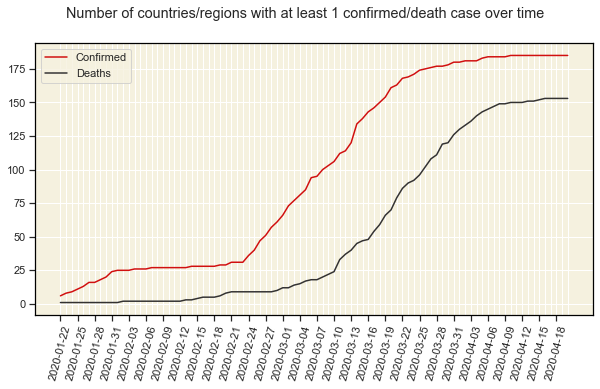

In [23]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.plot(dates,confirmed_countries, color = cconfirmed)
ax.plot(dates,deaths_countries, color = cdeaths)
plt.xticks(rotation=75)
ax.legend(['Confirmed', 'Deaths'])
fig.suptitle('Number of countries/regions with at least 1 confirmed/death case over time')
ax.set_xticks(dates)

every_nth = 3
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

for n, line in enumerate(ax.xaxis.get_ticklines()):
    if n % every_nth != 0:
        line.set_visible(False)

plt.savefig("img/num_of_countries.png",bbox_inches='tight')

In [24]:
# if index_start is negative plot will show this many days last days
#default index_end will be last  
def plot_one_country(country, index_start = 0, index_end = len(dates), every_nth = 3):
    
    minus = 0
    if index_start < 0:
        minus = -3
    
    country_confirmed = df_confirmed_gb[df_confirmed_gb['Country/Region']==country].iloc[:,3+index_start+minus:3+index_end]
    country_deaths = df_deaths_gb[df_deaths_gb['Country/Region']==country].iloc[:,3+index_start+minus:3+index_end]
    country_recovered = df_recovered_gb[df_recovered_gb['Country/Region']==country].iloc[:,3+index_start+minus:3+index_end]
    
    country_confirmed = country_confirmed.transpose()
    country_deaths = country_deaths.transpose()
    country_recovered = country_recovered.transpose()
    
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111)
    ax.plot(dates[index_start:index_end], country_confirmed, color = cconfirmed)
    ax.plot(dates[index_start:index_end], country_deaths, color = cdeaths)
    ax.plot(dates[index_start:index_end], country_recovered, color = crecovered)
    plt.xticks(rotation=75)
    ax.legend(['Confirmed', 'Deaths', 'Recovered'])
    fig.suptitle(country)
    ax.set_xticks(dates[index_start:index_end])

    #every_nth = 3
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)

    for n, line in enumerate(ax.xaxis.get_ticklines()):
        if n % every_nth != 0:
            line.set_visible(False)

    plt.savefig("img/{}.png".format(country),bbox_inches='tight')

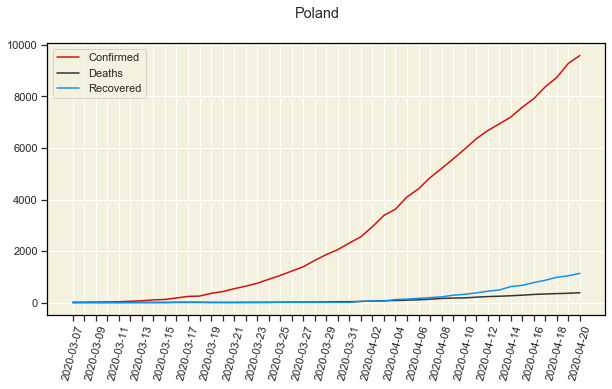

In [25]:
plot_one_country("Poland", every_nth = 2, index_start = 45)

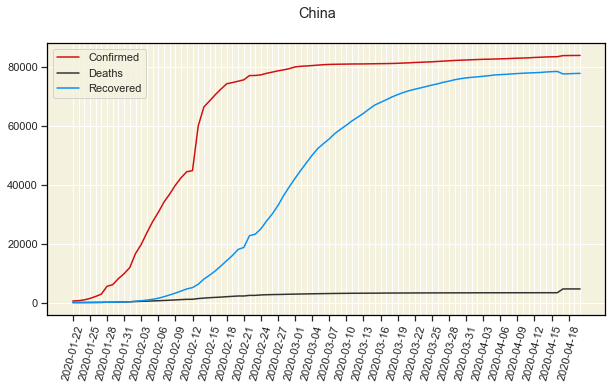

In [26]:
plot_one_country("China")

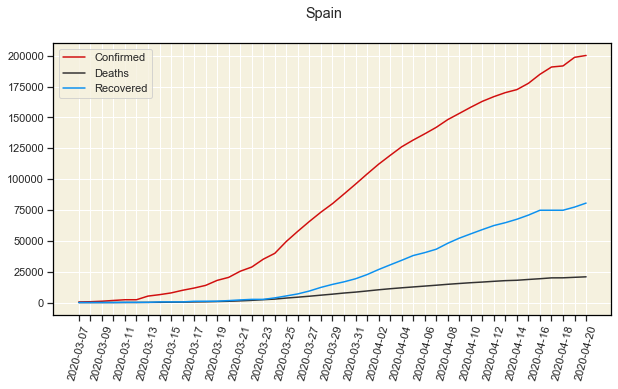

In [27]:
plot_one_country("Spain", every_nth = 2, index_start = 45)

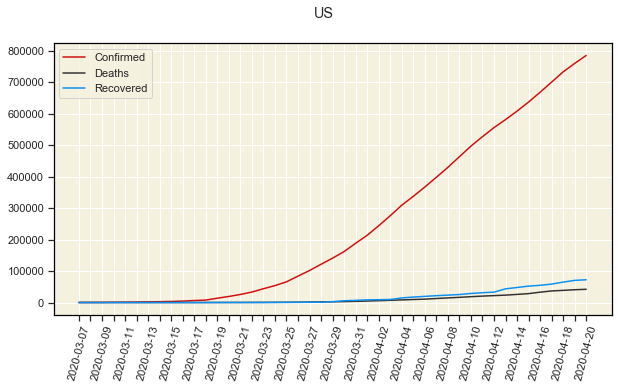

In [28]:
plot_one_country("US", every_nth = 2, index_start = 45)

In [29]:
# countries = df_confirmed['Country/Region'].unique()
countries = df_confirmed_gb['Country/Region'].unique()
print("Number of countries with at least 1 confirmed case: {}".format(len(countries)))
#print(countries)

Number of countries with at least 1 confirmed case: 185


In [30]:
#list of number of confirmed cases from last column
    
confirmed_country = df_confirmed_gb.iloc[:,-1].tolist()

cc_sort = confirmed_country.copy()
cc_sort.sort()
print("Sorted number of confirmed cases: {}".format(cc_sort))

Sorted number of confirmed cases: [1, 4, 4, 5, 5, 6, 7, 7, 9, 9, 10, 10, 10, 11, 12, 12, 14, 15, 15, 16, 16, 17, 18, 18, 19, 20, 22, 23, 24, 24, 25, 31, 33, 33, 39, 39, 39, 43, 50, 51, 54, 56, 57, 60, 65, 65, 67, 69, 75, 79, 81, 84, 94, 99, 107, 111, 114, 119, 120, 121, 122, 138, 147, 160, 208, 218, 223, 237, 246, 254, 256, 268, 281, 289, 304, 312, 328, 332, 377, 402, 422, 425, 431, 449, 462, 477, 510, 535, 564, 568, 581, 584, 622, 648, 662, 665, 677, 712, 717, 739, 772, 846, 847, 884, 929, 1026, 1042, 1087, 1163, 1173, 1225, 1309, 1326, 1335, 1339, 1410, 1436, 1440, 1535, 1574, 1627, 1773, 1852, 1881, 1907, 1984, 1995, 2245, 2548, 2718, 2792, 2941, 2948, 3046, 3300, 3333, 3558, 3868, 3977, 4467, 4964, 5425, 5710, 6015, 6264, 6459, 6547, 6630, 6760, 6900, 7156, 7265, 7711, 8014, 8261, 8418, 8936, 9593, 10128, 10484, 10507, 10674, 10797, 13713, 14777, 14795, 15652, 16325, 18539, 20863, 27944, 33588, 37657, 39983, 40743, 47121, 83505, 83817, 90980, 125856, 147065, 156480, 181228, 200210,

In [31]:
#print(dates)

In [32]:
# # I am not using it anymore
# def multi_plot_limits(png_name):
    
#     dictionary = {"Country": countries ,"Confirmed": confirmed_country}
#     countries_last_date = pd.DataFrame(dictionary)
#     in_limits = countries_last_date.apply(lambda x: False if x['Confirmed'] < limit_low else (False if x['Confirmed'] > limit_high else True), axis=1)
#     # print(in_limits)
#     how_many = len(in_limits[in_limits == True].index)
#     print('Number of countries with number of confirmed cases between {} and {}: {}'.format(limit_low,limit_high, how_many))
    
    
#     indexTrue = in_limits[ in_limits == False ].index.tolist()
#     indexFalse = in_limits[ in_limits == True ].index.tolist()
#     # #copying to not change original df
#     countries_in_limits = countries_last_date.copy()
#     countries_in_limits.drop(indexTrue, inplace=True, axis=0)
    
    
#     #define how many rows on how many countries in list without china
#     plots_in_col = math.ceil((how_many)/plots_in_row)

#     fig, axs = plt.subplots(plots_in_col, plots_in_row, figsize=(15, plots_in_col*4), sharey=True, sharex=True)
#     fig.autofmt_xdate(rotation = 65)  
#     axs0 = axs.shape[0]
#     axs1 = axs.shape[1]

#     i = 0
#     j = 0
    
#     date_fmt = mdates.DateFormatter('%Y-%m-%d')
    
#     for country in countries_in_limits["Country"]:
#         axs[i][j].plot(dates, df_confirmed[df_confirmed['Country/Region']==country].iloc[:,4:].sum(axis = 0), color = cconfirmed)
#         axs[i][j].plot(dates, df_deaths[df_deaths['Country/Region']==country].iloc[:,4:].sum(axis = 0), color = cdeaths)
#         axs[i][j].plot(dates, df_recovered[df_recovered['Country/Region']==country].iloc[:,4:].sum(axis = 0), color = crecovered)
#         axs[i][j].set_title(country)
#         #axs[i][j].set_xticklabels(rotation=75)

#         every_nth = 5
#         dates.freq = 'd'
#         list_dates = []
#         for d in range(len(dates)):
#             if d % every_nth == 0:
#                 list_dates.append(dates[d])
        
#         axs[i][j].set_xticks(list_dates)
#         axs[i][j].xaxis.set_major_formatter(date_fmt)
# #         for n, label in enumerate(axs[i][j].xaxis.get_ticklabels()):
# #             if n % every_nth != 0:
# #                 label.set_visible(False)

# #         for n, line in enumerate(axs[i][j].xaxis.get_ticklines()):
# #             if n % every_nth != 0:
# #                 line.set_visible(False)
    
#         i = i + 1
#         if i==plots_in_col:
#             i = 0
#             j = j + 1
#             if j==plots_in_row:
#                 j = 0
              
#     fig.suptitle('Countries with number of confirmed cases between {} and {}'.format(limit_low, limit_high))
#     fig.legend(['Confirmed', 'Deaths', 'Recovered'],loc='upper left', bbox_to_anchor=(0.11, 0., 0., 1.),bbox_transform=plt.gcf().transFigure)
#     plt.savefig(png_name,bbox_inches='tight')

In [33]:
df_nlargest = df_confirmed_gb.nlargest(11,df_confirmed_gb.columns[-1])
df_nlargest = df_nlargest.reset_index(drop = True)
df_nsmallest = df_nlargest.nsmallest(9, df_nlargest.columns[-1])
df_multiplot_confirmed = df_nsmallest.nlargest(9, df_nsmallest.columns[-1])
df_multiplot_deaths = df_deaths_gb[df_deaths_gb['Country/Region'].isin(df_multiplot_confirmed['Country/Region'].tolist())]
df_multiplot_recovered = df_recovered_gb[df_recovered_gb['Country/Region'].isin(df_multiplot_confirmed['Country/Region'].tolist())]

In [34]:
def multi_plot(png_name):
    
    plots_in_row = 3
    plots_in_col = 3

    fig, axs = plt.subplots(plots_in_col, plots_in_row, figsize=(15, plots_in_col*4), sharey=True, sharex=True)
    fig.autofmt_xdate(rotation = 65)  
    axs0 = axs.shape[0]
    axs1 = axs.shape[1]

    i = 0
    j = 0
    
    date_fmt = mdates.DateFormatter('%Y-%m-%d')
    
    
    for country in df_multiplot_confirmed['Country/Region']:
        axs[i][j].plot(dates, df_multiplot_confirmed[df_multiplot_confirmed['Country/Region']==country].iloc[0,3:].tolist(), color = cconfirmed)
        axs[i][j].plot(dates, df_multiplot_deaths[df_multiplot_deaths['Country/Region']==country].iloc[0,3:].tolist(), color = cdeaths)
        axs[i][j].plot(dates, df_multiplot_recovered[df_multiplot_recovered['Country/Region']==country].iloc[0,3:].tolist(), color = crecovered)
        axs[i][j].set_title(country, size = 'large')
        #axs[i][j].set_xticklabels(rotation=75)

        every_nth = 6
        dates.freq = 'd'
        list_dates = []
        for d in range(len(dates)):
            if d % every_nth == 0:
                list_dates.append(dates[d])
        
        axs[i][j].set_xticks(list_dates)
        axs[i][j].xaxis.set_major_formatter(date_fmt)
        
#         for n, label in enumerate(axs[i][j].xaxis.get_ticklabels()):
#             if n % every_nth != 0:
#                 label.set_visible(False)

#         for n, line in enumerate(axs[i][j].xaxis.get_ticklines()):
#             if n % every_nth != 0:
#                 line.set_visible(False)
    
        i = i + 1
        if i==plots_in_col:
            i = 0
            j = j + 1
            if j==plots_in_row:
                j = 0
              
    fig.suptitle('9 countries with most confirmed cases (without {} and {})'.format(df_nlargest["Country/Region"][0],df_nlargest["Country/Region"][1]),size='xx-large')
    fig.legend(['Confirmed', 'Deaths', 'Recovered'],loc='upper left', bbox_to_anchor=(0.11, 0., 0., 1.),bbox_transform=plt.gcf().transFigure)
    plt.savefig(png_name,bbox_inches='tight')

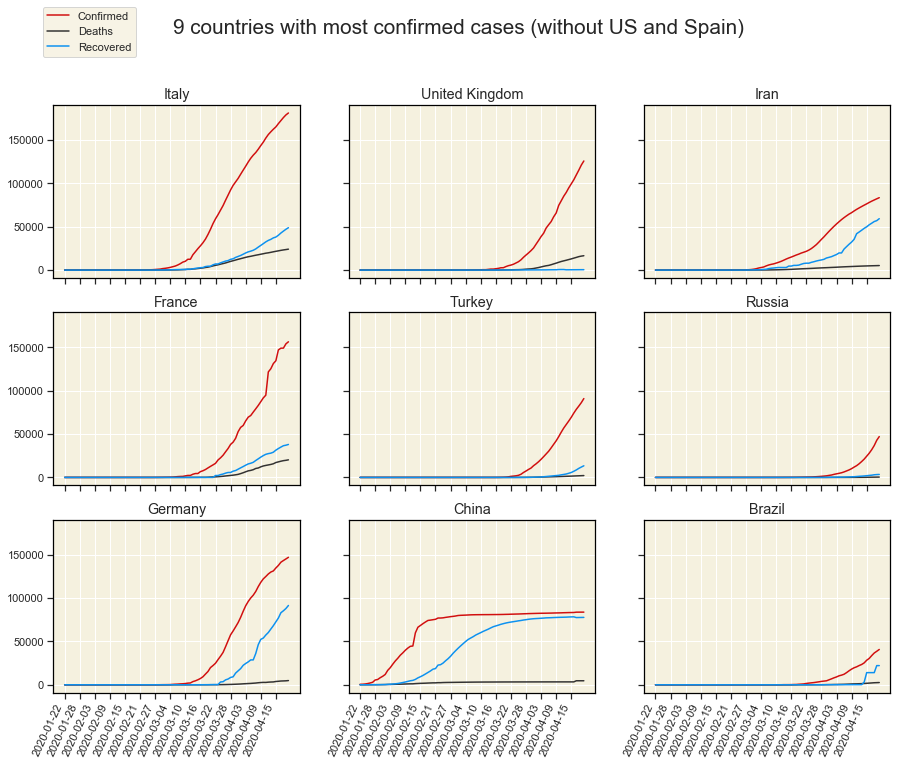

In [35]:
multi_plot('img/most_confirmed_cases.png')

In [36]:
df_confirmed_gb.iloc[:,4:].max().max()

784326

In [37]:
#not using now
def make_df_colCountry_rowValues(df, countries_ts):
    #new df - columns will be countries, index is date
    df_colCountry_rowConfirmed = pd.DataFrame()
    #print(df_colCountry_rowConfirmed)
    for i, country in enumerate(countries_ts,0):
        column = df[df['Country/Region']==country].iloc[:,4:].sum(axis=0)
        df_colCountry_rowConfirmed.insert(i, country, column)
    #print(df_colCountry_rowConfirmed.tail(3))
    return df_colCountry_rowConfirmed

In [38]:
# df_colCountry_rowConfirmed = make_df_colCountry_rowValues(df_confirmed, countries)
# df_colCountry_rowDeaths = make_df_colCountry_rowValues(df_deaths, countries)
# df_colCountry_rowRecovered = make_df_colCountry_rowValues(df_recovered, countries)

In [39]:
#przyrosty względne
# rel_change_confirmed = df_colCountry_rowConfirmed.pct_change()
rel_change_confirmed = df_confirmed_gb.iloc[:,3:].pct_change(axis= 1)
#print(rel_change_confirmed)

In [40]:
abs_change_confirmed = df_confirmed_gb.iloc[:,3:].diff(axis = 1)
abs_change_deaths = df_deaths_gb.iloc[:,3:].diff(axis = 1)
abs_change_recovered = df_recovered_gb.iloc[:,3:].diff(axis = 1)
print(abs_change_confirmed.head(3))

   1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  \
0      NaN      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1      NaN      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2      NaN      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

   1/30/20  1/31/20  ...  4/11/20  4/12/20  4/13/20  4/14/20  4/15/20  \
0      0.0      0.0  ...     34.0     52.0     58.0     49.0     70.0   
1      0.0      0.0  ...     17.0     13.0     21.0      8.0     19.0   
2      0.0      0.0  ...     64.0     89.0     69.0     87.0     90.0   

   4/16/20  4/17/20  4/18/20  4/19/20  4/20/20  
0     56.0     66.0     27.0     63.0     30.0  
1     24.0     21.0      9.0     14.0     22.0  
2    108.0    150.0    116.0     95.0     89.0  

[3 rows x 90 columns]


In [41]:
#plt.plot(df_colCountry_rowConfirmed["Mainland China"].diff())

In [42]:
daily_abs_change_confirmed_all = abs_change_confirmed.sum(axis=0)
daily_abs_change_deaths_all = abs_change_deaths.sum(axis=0)
daily_abs_change_recovered_all = abs_change_recovered.sum(axis=0)

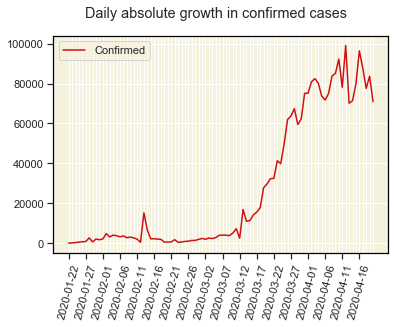

In [43]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.plot(dates, daily_abs_change_confirmed_all, color = cconfirmed)
plt.xticks(rotation=75)
ax.legend(['Confirmed'])
fig.suptitle('Daily absolute growth in confirmed cases')
ax.set_xticks(dates)

every_nth = 5
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

for n, line in enumerate(ax.xaxis.get_ticklines()):
    if n % every_nth != 0:
        line.set_visible(False)

plt.savefig("img/abs_growth_confirmed.png",bbox_inches='tight')

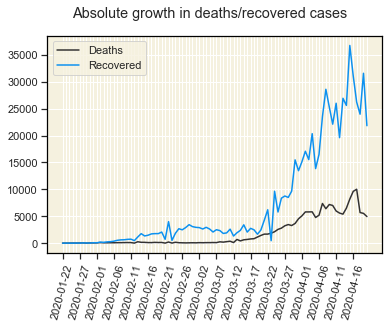

In [44]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.plot(dates, daily_abs_change_deaths_all, color = cdeaths)
ax.plot(dates, daily_abs_change_recovered_all, color = crecovered)
plt.xticks(rotation=75)
ax.legend(['Deaths', 'Recovered'])
fig.suptitle('Absolute growth in deaths/recovered cases')
ax.set_xticks(dates)

every_nth = 5
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

for n, line in enumerate(ax.xaxis.get_ticklines()):
    if n % every_nth != 0:
        line.set_visible(False)

plt.savefig("img/abs_growth_deaths_recovered.png",bbox_inches='tight')

In [45]:
from bokeh.plotting import figure, output_notebook, output_file, show
from bokeh.models import HoverTool, ColumnDataSource

In [46]:
dates

DatetimeIndex(['2020-01-22', '2020-01-23', '2020-01-24', '2020-01-25',
               '2020-01-26', '2020-01-27', '2020-01-28', '2020-01-29',
               '2020-01-30', '2020-01-31', '2020-02-01', '2020-02-02',
               '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06',
               '2020-02-07', '2020-02-08', '2020-02-09', '2020-02-10',
               '2020-02-11', '2020-02-12', '2020-02-13', '2020-02-14',
               '2020-02-15', '2020-02-16', '2020-02-17', '2020-02-18',
               '2020-02-19', '2020-02-20', '2020-02-21', '2020-02-22',
               '2020-02-23', '2020-02-24', '2020-02-25', '2020-02-26',
               '2020-02-27', '2020-02-28', '2020-02-29', '2020-03-01',
               '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05',
               '2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09',
               '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13',
               '2020-03-14', '2020-03-15', '2020-03-16', '2020-03-17',
      

In [47]:
df_confirmed_gb_trans = df_confirmed_gb.transpose().reset_index()
df_confirmed_gb_trans.columns = df_confirmed_gb_trans.iloc[0]
df_confirmed_gb_trans = df_confirmed_gb_trans.drop([0,1,2], axis = 0).reset_index()
df_confirmed_gb_trans = df_confirmed_gb_trans.drop("index", axis = 1)

In [48]:
df_confirmed_gb_trans["Country/Region"] = dates 

In [49]:
df_confirmed_gb_trans = df_confirmed_gb_trans.rename(columns = {"Country/Region": "Date"})

In [50]:
# df_confirmed_gb_trans

In [51]:
df_confirmed_gb[df_confirmed_gb["Country/Region"] == "Poland"].iloc[:,3:]

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20
134,0,0,0,0,0,0,0,0,0,0,...,6356,6674,6934,7202,7582,7918,8379,8742,9287,9593


In [52]:
output_file("docs/poland_russia.html")

source = ColumnDataSource(data=df_confirmed_gb_trans)

hovertool = HoverTool(
    tooltips=[
        ('Date', '@Date{%F}'),
        ('Poland', '@Poland'),
        ('Russia', '@Russia'),
    ],

    formatters={
        '@Date': 'datetime', # use 'datetime' formatter for '@date' field
    },

    # display a tooltip whenever the cursor is vertically in line with a glyph
    mode='vline'
)

p = figure(title="Mouse over the dots", tools="pan,wheel_zoom,reset,save", x_axis_type='datetime', plot_width=1000)

p.add_tools(hovertool)

p.circle('Date', 'Poland', source=source, color = "red")
p.line('Date', 'Poland', source=source)
p.circle('Date', 'Russia', source=source, color = "red")
p.line('Date', 'Russia', source=source)

show(p)

In [53]:
# df_confirmed_gb_trans

In [54]:
df_100 = pd.DataFrame()
df_100 = df_100.reindex(columns = df_confirmed_gb_trans.columns[1:])
#dodanie pustego wiersza
nans = np.full(len(df_confirmed_gb_trans.columns[1:]), np.nan)
df_100 = df_100.append(pd.Series(nans,index = df_confirmed_gb_trans.columns[1:]), ignore_index = True)
df_100

,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Yemen,Zambia,Zimbabwe
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
for col in df_confirmed_gb_trans.columns[1:]:
    wiersze = 0
    for i in range(df_confirmed_gb_trans.shape[0]):
        if (df_100.shape[0] <= wiersze):
            df_100 = df_100.append(pd.Series(nans,index = df_confirmed_gb_trans.columns[1:]), ignore_index = True)
        if df_confirmed_gb_trans[col][i] >= 100:
            df_100[col][wiersze] = df_confirmed_gb_trans[col][i]
            wiersze = wiersze + 1
            
# df_100

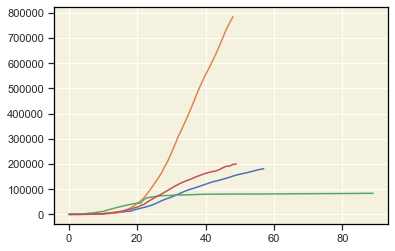

In [56]:
plt.plot(df_100["Italy"])
plt.plot(df_100["US"])
plt.plot(df_100["China"])
plt.plot(df_100["Spain"])

In [57]:
population = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv")

In [58]:
population["Country/Region"] = population["Combined_Key"]
population = population[["Country/Region", "Population"]]

In [59]:
population[population["Country/Region"]=="US"]

,Country/Region,Population
266,US,329466283.0


In [60]:
df_confirmed_gb_pop = pd.merge(df_confirmed_gb, population,on="Country/Region")

In [61]:
df_confirmed_gb_pop = df_confirmed_gb_pop.drop(["Lat","Long"],axis=1)

In [62]:
df_confirmed_gb_pop

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,Population
0,Afghanistan,0,0,0,0,0,0,0,0,0,...,607,665,714,784,840,906,933,996,1026,38928341.0
1,Albania,0,0,0,0,0,0,0,0,0,...,446,467,475,494,518,539,548,562,584,2877800.0
2,Algeria,0,0,0,0,0,0,0,0,0,...,1914,1983,2070,2160,2268,2418,2534,2629,2718,43851043.0
3,Andorra,0,0,0,0,0,0,0,0,0,...,638,646,659,673,673,696,704,713,717,77265.0
4,Angola,0,0,0,0,0,0,0,0,0,...,19,19,19,19,19,19,24,24,24,32866268.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,West Bank and Gaza,0,0,0,0,0,0,0,0,0,...,290,308,308,374,374,402,418,437,449,5101416.0
181,Western Sahara,0,0,0,0,0,0,0,0,0,...,6,6,6,6,6,6,6,6,6,597330.0
182,Yemen,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,29825968.0
183,Zambia,0,0,0,0,0,0,0,0,0,...,43,45,45,48,48,52,57,61,65,18383956.0


In [90]:
df_confirmed_gb_per_mil = pd.DataFrame()
df_confirmed_gb_per_mil["Country/Region"] = df_confirmed_gb_pop["Country/Region"]

In [94]:
for col in df_confirmed_gb_pop.columns[1:-1]:
    df_confirmed_gb_per_mil[col] = df_confirmed_gb_pop[col]/df_confirmed_gb_pop["Population"]*1000000

In [95]:
df_confirmed_gb_per_mil

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20
0,Afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14.256965,15.592753,17.082670,18.341393,20.139569,21.578109,23.273532,23.967114,25.585473,26.356119
1,Albania,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,150.462159,154.979498,162.276739,165.056640,171.658906,179.998610,187.295851,190.423240,195.288067,202.932796
2,Algeria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,41.618166,43.647765,45.221273,47.205263,49.257665,51.720549,55.141220,57.786539,59.952964,61.982562
3,Andorra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7778.424901,8257.296318,8360.836084,8529.088203,8710.282793,8710.282793,9007.959619,9111.499385,9227.981622,9279.751505
4,Angola,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.578100,0.578100,0.578100,0.578100,0.578100,0.578100,0.578100,0.730232,0.730232,0.730232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,West Bank and Gaza,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,52.534434,56.846962,60.375394,60.375394,73.312978,73.312978,78.801650,81.938034,85.662491,88.014779
181,Western Sahara,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.696466,10.044699,10.044699,10.044699,10.044699,10.044699,10.044699,10.044699,10.044699,10.044699
182,Yemen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.033528,0.033528,0.033528,0.033528,0.033528,0.033528,0.033528,0.033528,0.033528,0.033528
183,Zambia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.175810,2.338996,2.447787,2.447787,2.610972,2.610972,2.828553,3.100530,3.318111,3.535692
